In [1]:
import torch

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import cupy as cp
from cucim.skimage import measure as cucim_measure

In [2]:
def plot(pred, gt_display):
    pred = pred.cpu().numpy()
    gt_display = gt_display.cpu().numpy()
    gt_display = gt_display*2

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(pred[0, :, :], cmap='gray')
    ax[0].set_title('Prediction', fontsize=15)

    ax[1].imshow(gt_display[0, :, :], cmap='gray')
    ax[1].set_title('Ground Truth', fontsize=15)

    combined = pred + gt_display

    ax[2].imshow(combined[0, :, :], cmap='rainbow')
    ax[2].set_title('Overlay (Pred +  GT)', fontsize=15)

    legend_elements = [Patch(facecolor='purple', edgecolor='black', label='TN'),
                    Patch(facecolor='turquoise', edgecolor='black', label='FP'),
                    Patch(facecolor='orange', edgecolor='black', label='FN'),
                    Patch(facecolor='red', edgecolor='black', label='TP')]

    ax[2].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))

    plt.show()

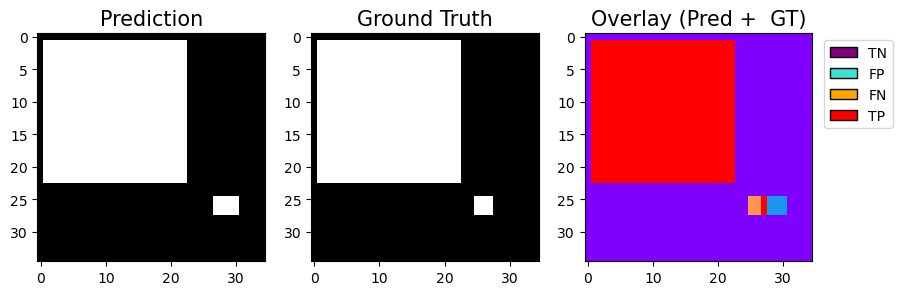

In [3]:
pred = torch.zeros((10, 35, 35)).cuda()
gt   = torch.zeros((10, 35, 35)).cuda()

pred[0, 1:23, 1:23] = 1
gt[0, 1:23, 1:23] = 1

pred[0, 25:28, 27:31] = 1
gt[0, 25:28, 25:28] = 1

plot(pred, gt*2)

# Original -- VERY WRONG

In [4]:
import numpy as np
import pandas as pd

def get_connected_components(img):
    img_cupy = cp.asarray(img)
    labeled_img, num_features = cucim_measure.label(img_cupy, return_num=True)
    labeled_img_torch = torch.as_tensor(labeled_img, device=img.device)
    return labeled_img_torch, num_features

def calculate_iou(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    return iou

def get_detection_metrics(gt, pred):

    # Define IoU thresholds
    iou_thresholds = [0.00001, 0.1, 0.25, 0.5, 0.75, 1.0]

    # Initialize lesion counts for the case
    lesion_counts = {'greater_than_10cc': {'gt': 0, 'pred': 0},
                        '5_to_10cc': {'gt': 0, 'pred': 0},
                        'less_than_5cc': {'gt': 0, 'pred': 0}}

    labeled_img, num_features_gt = get_connected_components(gt)
    pred_labeled_img, num_features_pred = get_connected_components(pred)

    # Initialize the master table DataFrame
    master_table = pd.DataFrame(columns=[
        'Threshold', 
        'Lesion_ID', 'Lesion_Size', 'Size_Category', 'IoU', 'Overlap', 
    ])

    # Iterate through ground truth lesions
    for feature in range(1, num_features_gt + 1):
        component_size = (labeled_img == feature).sum().item()

        # Assign size category based on component size
        if component_size > 1000:
            size_category = 'greater_than_10cc'
        elif 25 <= component_size <= 1000:
            size_category = '5_to_10cc'
        else:
            size_category = 'less_than_5cc'

        # Increment ground truth lesion count for this size category
        lesion_counts[size_category]['gt'] += 1

        # Calculate IoU for this lesion
        gt_mask = (labeled_img == feature).cpu().numpy()
        pred_mask = pred_labeled_img.cpu().numpy() > 0

        for threshold in iou_thresholds:
            iou = calculate_iou(gt_mask, pred_mask)
            overlap = iou > threshold

            # Add row to master table
            master_table = pd.concat(
                [master_table, pd.DataFrame({
                    'Trainer' : ['Trainer'],
                    'Threshold': [threshold],
                    'Lesion_ID': [feature],
                    'Lesion_Size': [component_size],
                    'Size_Category': [size_category],
                    'IoU': [iou],
                    'Overlap': [overlap],
                })],
                ignore_index=True
            )

    # Iterate through predicted lesions and update lesion counts for predicted size categories
    for feature in range(1, num_features_pred + 1):
        pred_component_size = (pred_labeled_img == feature).sum().item()

        # Assign size category for prediction
        if pred_component_size > 1000:
            pred_size_category = 'greater_than_10cc'
        elif 25 <= pred_component_size <= 1000:
            pred_size_category = '5_to_10cc'
        else:
            pred_size_category = 'less_than_5cc'

        # Increment predicted lesion count for this size category
        lesion_counts[pred_size_category]['pred'] += 1

    return master_table

master_table = get_detection_metrics(gt, pred)
print(master_table.to_string())

    Threshold Lesion_ID Lesion_Size  Size_Category       IoU Overlap  Trainer
0     0.00001         1         484      5_to_10cc  0.975806    True  Trainer
1     0.10000         1         484      5_to_10cc  0.975806    True  Trainer
2     0.25000         1         484      5_to_10cc  0.975806    True  Trainer
3     0.50000         1         484      5_to_10cc  0.975806    True  Trainer
4     0.75000         1         484      5_to_10cc  0.975806    True  Trainer
5     1.00000         1         484      5_to_10cc  0.975806   False  Trainer
6     0.00001         2           9  less_than_5cc  0.005976    True  Trainer
7     0.10000         2           9  less_than_5cc  0.005976   False  Trainer
8     0.25000         2           9  less_than_5cc  0.005976   False  Trainer
9     0.50000         2           9  less_than_5cc  0.005976   False  Trainer
10    0.75000         2           9  less_than_5cc  0.005976   False  Trainer
11    1.00000         2           9  less_than_5cc  0.005976   F

# NEW -- IOU

In [ ]:
def calculate_iou(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    return iou

def get_detection_metrics(pred, gt):

    # Initialize lesion counts for the case
    lesion_counts = {'greater_than_10cc': {'gt': 0, 'pred': 0},
                     '5_to_10cc': {'gt': 0, 'pred': 0},
                     'less_than_5cc': {'gt': 0, 'pred': 0}}

    # Define IoU thresholds
    iou_thresholds = [0.00001, 0.1, 0.25, 0.5, 0.75, 1.0]

    labeled_img, num_features_gt = get_connected_components(gt)
    pred_labeled_img, num_features_pred = get_connected_components(pred)    

    labeled_img = labeled_img.cpu().numpy()
    pred_labeled_img = pred_labeled_img.cpu().numpy()

    # Initialize the master table DataFrame
    master_table = pd.DataFrame(columns=[
        'Threshold', 
        'Lesion_ID', 'Lesion_Size', 'Size_Category', 'IoU', 'Overlap', 
    ])

    # Iterate through ground truth lesions
    for feature in range(1, num_features_gt + 1):
        component_size = (labeled_img == feature).sum().item()

        # Assign size category based on component size
        if component_size > 1000:
            size_category = 'greater_than_10cc'
        elif 25 <= component_size <= 1000:
            size_category = '5_to_10cc'
        else:
            size_category = 'less_than_5cc'

        # Increment ground truth lesion count for this size category
        lesion_counts[size_category]['gt'] += 1

        # Get the ground truth mask for the current GT component
        gt_mask = (labeled_img == feature)

        # Identify the prediction labels that overlap with the GT component
        overlapping_pred_labels = np.unique(pred_labeled_img[gt_mask > 0])

        # Remove background label (0)
        overlapping_pred_labels = overlapping_pred_labels[overlapping_pred_labels > 0]

        # If there are multiple overlapping prediction components, find the one with the largest intersection
        max_overlap = 0
        best_matching_pred_label = None
        for label in overlapping_pred_labels:
            pred_mask_candidate = (pred_labeled_img == label)
            overlap_area = np.logical_and(gt_mask, pred_mask_candidate).sum()
            if overlap_area > max_overlap:
                max_overlap = overlap_area
                best_matching_pred_label = label

        # If a corresponding prediction component is found, extract its mask
        if best_matching_pred_label is not None:
            pred_mask = (pred_labeled_img == best_matching_pred_label)
        else:
            # If no overlapping prediction is found, set pred_mask to be an empty mask of the same shape
            pred_mask = np.zeros_like(gt_mask)

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(gt_mask[0])
        ax[0].set_title('Ground Truth')
        ax[1].imshow(pred_mask[0])
        ax[1].set_title('Prediction')

        for threshold in iou_thresholds:
            iou = calculate_iou(gt_mask, pred_mask)
            overlap = iou > threshold

            # Add row to master table
            master_table = pd.concat(
                [master_table, pd.DataFrame({
                    'Trainer' : ['Trainer'],
                    'Threshold': [threshold],
                    'Lesion_ID': [feature],
                    'Lesion_Size': [component_size],
                    'Size_Category': [size_category],
                    'IoU': [iou],
                    'Overlap': [overlap],
                })],
                ignore_index=True
            )

    # Iterate through predicted lesions and update lesion counts for predicted size categories
    for feature in range(1, num_features_pred + 1):
        pred_component_size = (pred_labeled_img == feature).sum().item()

        # Assign size category for prediction
        if pred_component_size > 1000:
            pred_size_category = 'greater_than_10cc'
        elif 25 <= pred_component_size <= 1000:
            pred_size_category = '5_to_10cc'
        else:
            pred_size_category = 'less_than_5cc'

        # Increment predicted lesion count for this size category
        lesion_counts[pred_size_category]['pred'] += 1

    # return master_table
    print(master_table)


In [ ]:
def calculate_iou(gt_mask, pred_mask):
    intersection = torch.logical_and(gt_mask, pred_mask)
    union = torch.logical_or(gt_mask, pred_mask)
    iou = torch.sum(intersection) / torch.sum(union) if torch.sum(union) > 0 else 0
    return iou

def get_detection_metrics(pred, gt):

    # Initialize lesion counts for the case
    lesion_counts = {'greater_than_10cc': {'gt': 0, 'pred': 0},
                     '5_to_10cc': {'gt': 0, 'pred': 0},
                     'less_than_5cc': {'gt': 0, 'pred': 0}}

    # Define IoU thresholds
    iou_thresholds = [0.00001, 0.1, 0.25, 0.5, 0.75, 1.0]

    labeled_img, num_features_gt = get_connected_components(gt)
    pred_labeled_img, num_features_pred = get_connected_components(pred)    

    # Initialize the master table DataFrame
    master_table = pd.DataFrame(columns=[
        'Threshold', 
        'Lesion_ID', 'Lesion_Size', 'Size_Category', 'IoU', 'Overlap', 
    ])

    # Iterate through ground truth lesions
    for feature in range(1, num_features_gt + 1):
        component_size = (labeled_img == feature).sum().item()

        # Assign size category based on component size
        if component_size > 1000:
            size_category = 'greater_than_10cc'
        elif 25 <= component_size <= 1000:
            size_category = '5_to_10cc'
        else:
            size_category = 'less_than_5cc'

        # Increment ground truth lesion count for this size category
        lesion_counts[size_category]['gt'] += 1

        # Get the ground truth mask for the current GT component
        gt_mask = (labeled_img == feature)

        # Identify the prediction labels that overlap with the GT component
        overlapping_pred_labels = torch.unique(pred_labeled_img[gt_mask > 0])

        # Remove background label (0)
        overlapping_pred_labels = overlapping_pred_labels[overlapping_pred_labels > 0]

        # If a corresponding prediction component is found, extract its mask
        if overlapping_pred_labels is not None:
            pred_mask = (pred_labeled_img == overlapping_pred_labels)
        else:
            # If no overlapping prediction is found, set pred_mask to be an empty mask of the same shape
            pred_mask = torch.zeros_like(gt_mask)

        for threshold in iou_thresholds:
            iou = calculate_iou(gt_mask, pred_mask)
            iou = iou.cpu().numpy()
            overlap = iou > threshold

            # Add row to master table
            master_table = pd.concat(
                [master_table, pd.DataFrame({
                    'Trainer' : ['Trainer'],
                    'Threshold': [threshold],
                    'Lesion_ID': [feature],
                    'Lesion_Size': [component_size],
                    'Size_Category': [size_category],
                    'IoU': [iou],
                    'Overlap': [overlap],
                })],
                ignore_index=True
            )

    # Iterate through predicted lesions and update lesion counts for predicted size categories
    for feature in range(1, num_features_pred + 1):
        pred_component_size = (pred_labeled_img == feature).sum().item()

        # Assign size category for prediction
        if pred_component_size > 1000:
            pred_size_category = 'greater_than_10cc'
        elif 25 <= pred_component_size <= 1000:
            pred_size_category = '5_to_10cc'
        else:
            pred_size_category = 'less_than_5cc'

        # Increment predicted lesion count for this size category
        lesion_counts[pred_size_category]['pred'] += 1

    # return master_table
    print(master_table)


# NEW - I

In [6]:
def calculate_intersection(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask)
    return intersection

def get_detection_metrics(pred, gt):

    # Initialize lesion counts for the case
    lesion_counts = {'greater_than_10cc': {'gt': 0, 'pred': 0},
                     '5_to_10cc': {'gt': 0, 'pred': 0},
                     'less_than_5cc': {'gt': 0, 'pred': 0}}

    # Define IoU thresholds
    iou_thresholds = [0.00001, 0.1, 0.25, 0.5, 0.75, 1.0]

    labeled_img, num_features_gt = get_connected_components(gt)
    pred_labeled_img, num_features_pred = get_connected_components(pred)    

    labeled_img = labeled_img.cpu().numpy()
    pred_labeled_img = pred_labeled_img.cpu().numpy()

    # Initialize the master table DataFrame
    master_table = pd.DataFrame(columns=[
        'Threshold', 
        'Lesion_ID', 'Lesion_Size', 'Size_Category', 'IoU', 'Overlap', 
    ])

    # Iterate through ground truth lesions
    for feature in range(1, num_features_gt + 1):
        component_size = (labeled_img == feature).sum().item()

        # Assign size category based on component size
        if component_size > 1000:
            size_category = 'greater_than_10cc'
        elif 25 <= component_size <= 1000:
            size_category = '5_to_10cc'
        else:
            size_category = 'less_than_5cc'

        # Increment ground truth lesion count for this size category
        lesion_counts[size_category]['gt'] += 1

        # Get the ground truth mask for the current GT component
        gt_mask = (labeled_img == feature)

        # Identify the prediction labels that overlap with the GT component
        overlapping_pred_labels = np.unique(pred_labeled_img[gt_mask > 0])

        # Remove background label (0)
        overlapping_pred_labels = overlapping_pred_labels[overlapping_pred_labels > 0]

        # If there are multiple overlapping prediction components, find the one with the largest intersection
        max_overlap = 0
        best_matching_pred_label = None
        for label in overlapping_pred_labels:
            pred_mask_candidate = (pred_labeled_img == label)
            overlap_area = np.logical_and(gt_mask, pred_mask_candidate).sum()
            if overlap_area > max_overlap:
                max_overlap = overlap_area
                best_matching_pred_label = label

        # If a corresponding prediction component is found, extract its mask
        if best_matching_pred_label is not None:
            pred_mask = (pred_labeled_img == best_matching_pred_label)
        else:
            # If no overlapping prediction is found, set pred_mask to be an empty mask of the same shape
            pred_mask = np.zeros_like(gt_mask)

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(gt_mask[0])
        ax[0].set_title('Ground Truth')
        ax[1].imshow(pred_mask[0])
        ax[1].set_title('Prediction')

        for threshold in iou_thresholds:
            iou = calculate_iou(gt_mask, pred_mask)
            overlap = iou > threshold

            # Add row to master table
            master_table = pd.concat(
                [master_table, pd.DataFrame({
                    'Trainer' : ['Trainer'],
                    'Threshold': [threshold],
                    'Lesion_ID': [feature],
                    'Lesion_Size': [component_size],
                    'Size_Category': [size_category],
                    'IoU': [iou],
                    'Overlap': [overlap],
                })],
                ignore_index=True
            )

    # Iterate through predicted lesions and update lesion counts for predicted size categories
    for feature in range(1, num_features_pred + 1):
        pred_component_size = (pred_labeled_img == feature).sum().item()

        # Assign size category for prediction
        if pred_component_size > 1000:
            pred_size_category = 'greater_than_10cc'
        elif 25 <= pred_component_size <= 1000:
            pred_size_category = '5_to_10cc'
        else:
            pred_size_category = 'less_than_5cc'

        # Increment predicted lesion count for this size category
        lesion_counts[pred_size_category]['pred'] += 1

    # return master_table
    print(master_table)


    Threshold  Trainer  Size_Category  Overlap
0     0.00001  Trainer      5_to_10cc      1.0
1     0.00001  Trainer  less_than_5cc      1.0
2     0.10000  Trainer      5_to_10cc      1.0
3     0.10000  Trainer  less_than_5cc      0.0
4     0.25000  Trainer      5_to_10cc      1.0
5     0.25000  Trainer  less_than_5cc      0.0
6     0.50000  Trainer      5_to_10cc      1.0
7     0.50000  Trainer  less_than_5cc      0.0
8     0.75000  Trainer      5_to_10cc      1.0
9     0.75000  Trainer  less_than_5cc      0.0
10    1.00000  Trainer      5_to_10cc      0.0
11    1.00000  Trainer  less_than_5cc      0.0


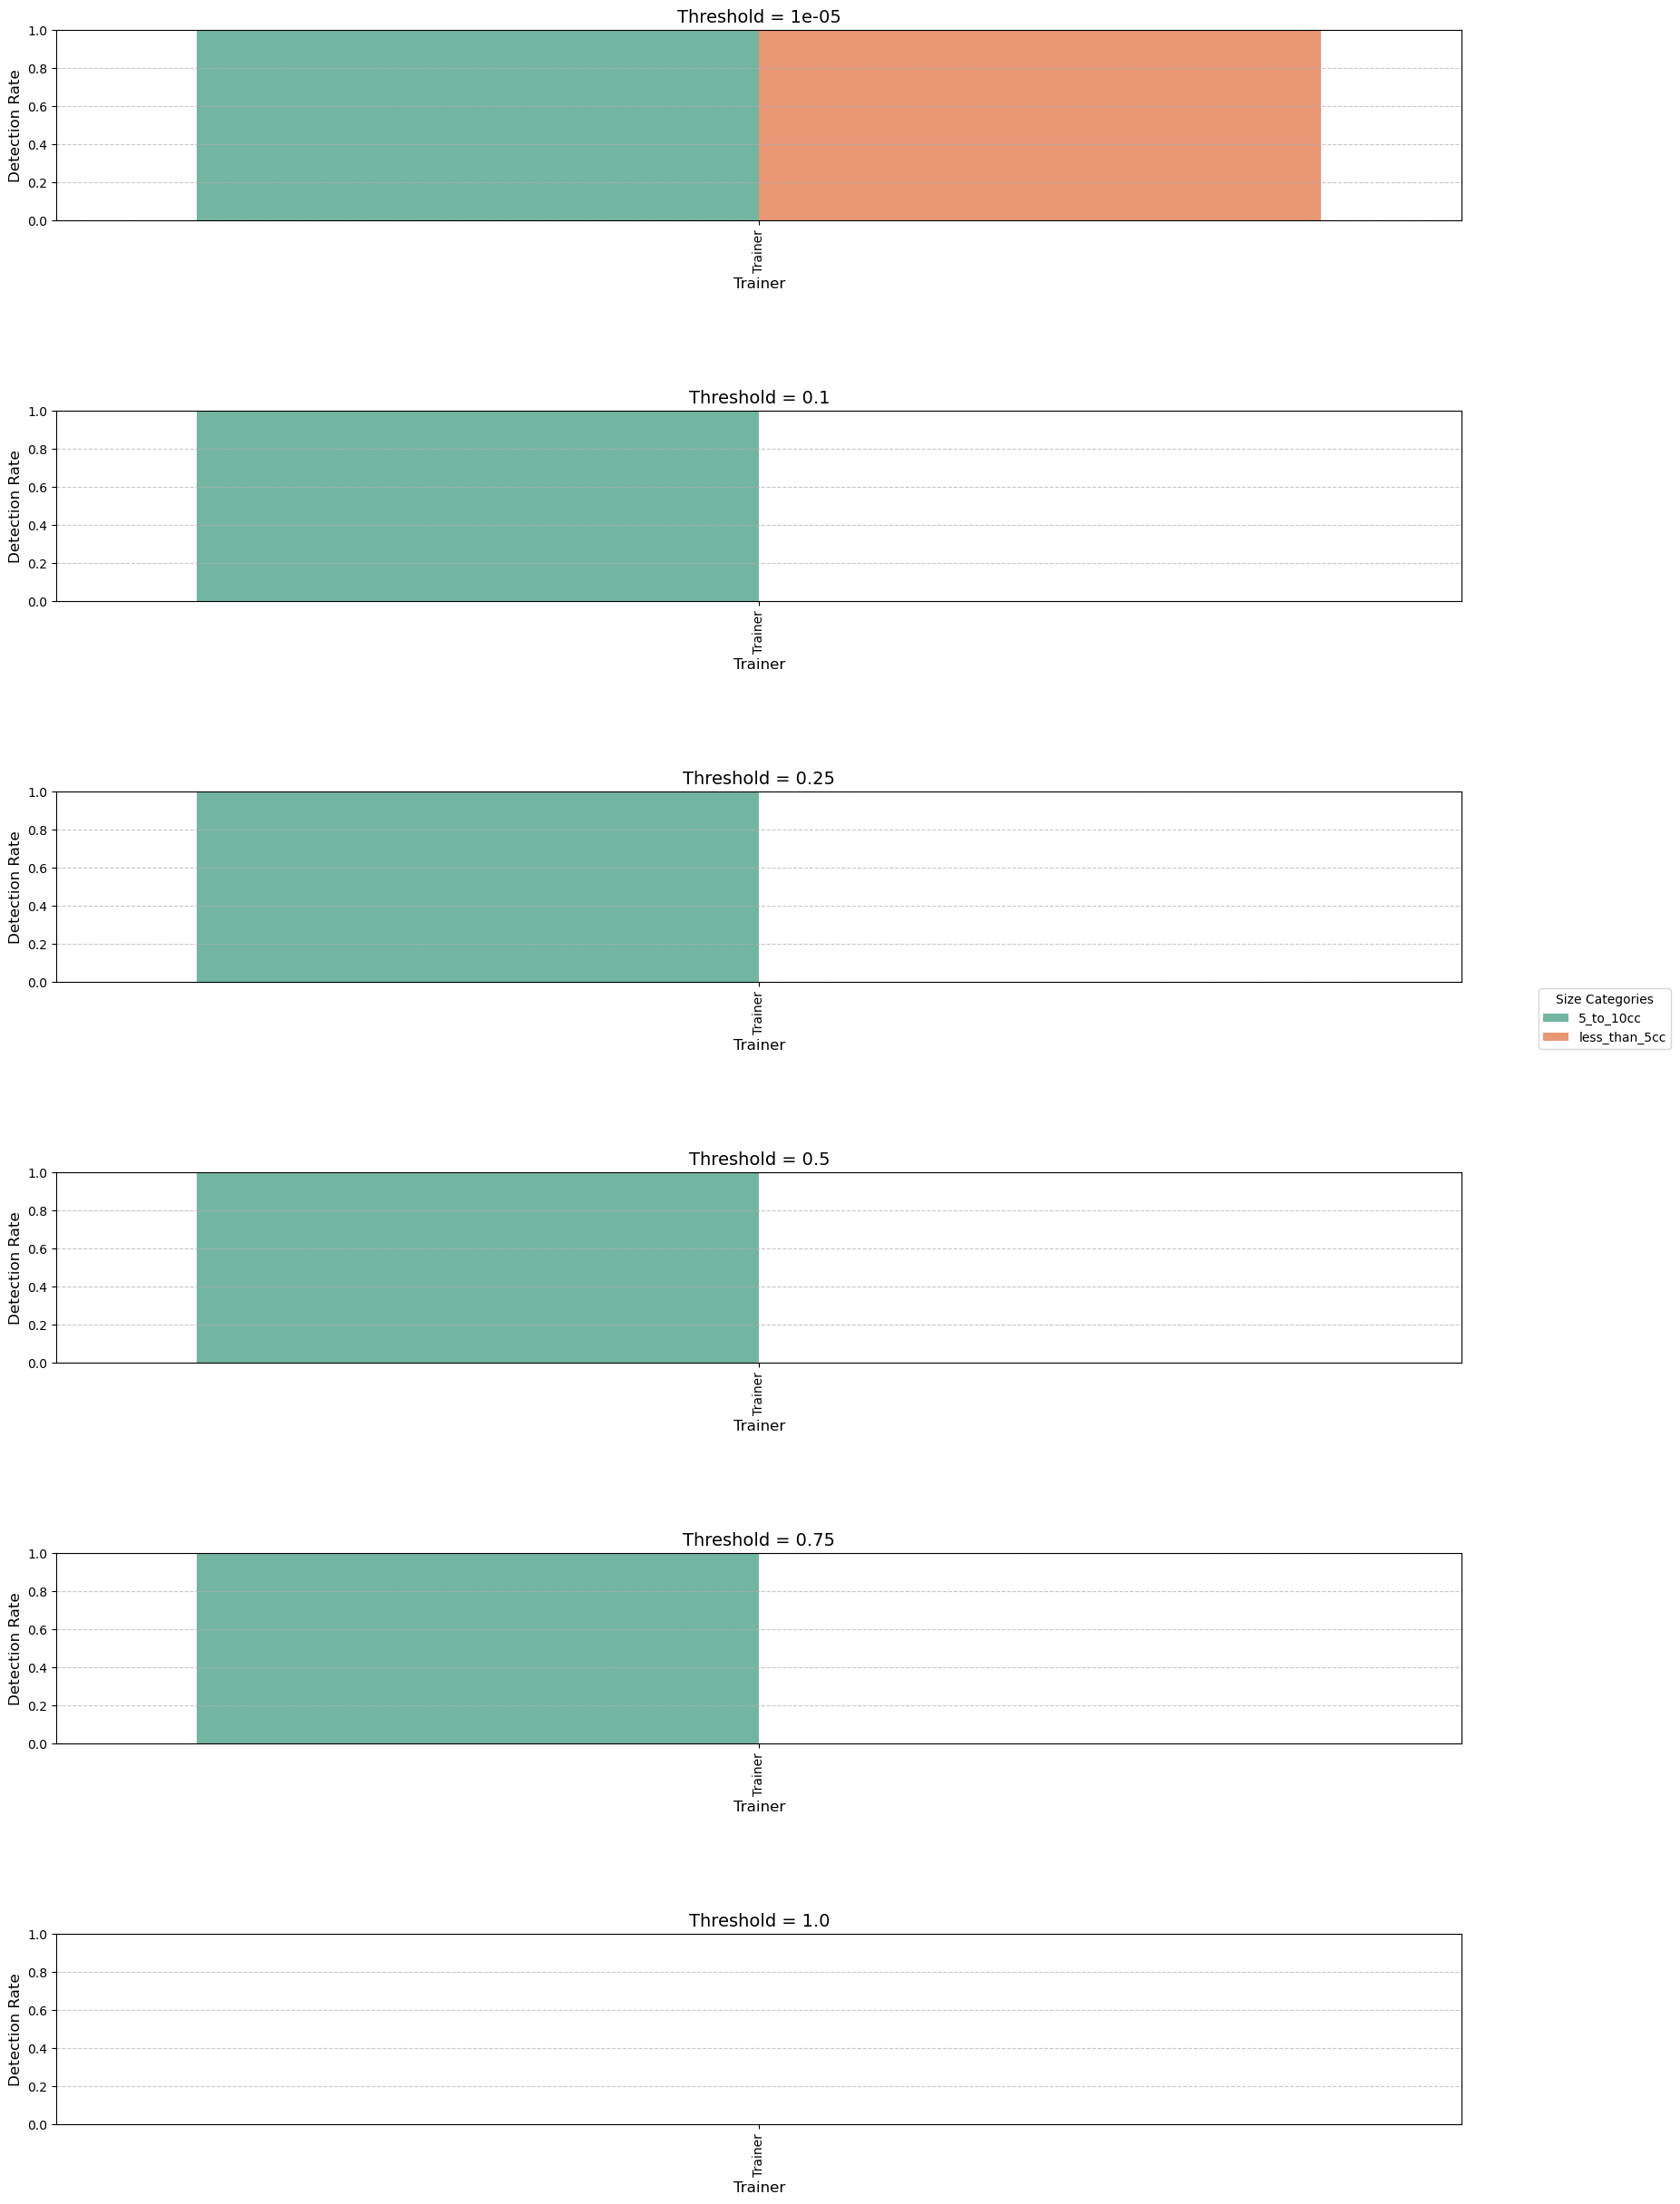

In [7]:
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

table = master_table.copy()

# Convert Overlap to binary (1 for True, 0 for False)
table['Overlap'] = table['Overlap'].astype(int)

# Compute detection rate per trainer, per threshold, and size category
detection_rate = (
    table.groupby(['Threshold', 'Trainer', 'Size_Category'])['Overlap']
    .mean()
    .reset_index()
)

print(detection_rate.to_string())

# Automatically assign random colors to trainers
trainers = detection_rate['Trainer'].unique()
trainer_colors = {trainer: f"#{random.randint(0, 0xFFFFFF):06x}" for trainer in trainers}

# Get unique thresholds and size categories
thresholds = detection_rate['Threshold'].unique()
size_categories = table['Size_Category'].unique()

# Plot
plt.figure(figsize=(20, len(thresholds) * 5))  # Adjust figure size for more thresholds
for i, threshold in enumerate(thresholds, 1):
    plt.subplot(len(thresholds), 1, i)
    subset = detection_rate[detection_rate['Threshold'] == threshold]

    # Order the trainers by their detection rate in descending order
    subset = subset.sort_values('Overlap', ascending=False)

    # Set up a barplot for each size category
    ax = sns.barplot(
        x='Trainer', y='Overlap', hue='Size_Category', data=subset,
        palette='Set2'
    )
    ax.set_title(f'Threshold = {threshold}', fontsize=14)
    ax.set_xlabel('Trainer', fontsize=12)
    ax.set_ylabel('Detection Rate', fontsize=12)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rotate x-axis tick labels
    ax.legend_.remove()  # Remove the legend generated by sns.barplot

# Add a legend for size categories
plt.legend(title="Size Categories", bbox_to_anchor=(1.05, len(thresholds)), loc='upper left')

# Adjust layout to add vertical space between plots
plt.subplots_adjust(hspace=1)

plt.tight_layout()
plt.show()